## Imports

In [1]:
import pandas as pd
import numpy as np

import pickle

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE


import featuretools as ft
import featuretools.variable_types as vtypes

import datetime

from bokeh.models import HoverTool
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot


Populating the interactive namespace from numpy and matplotlib


## Open Pickled Data

In [2]:
with open('traf_sample_red.pickle','rb') as read_file:
    traf_sample_red = pickle.load(read_file)

In [3]:
traf_sample_red.head()

,Location,timestamp,Obs_Speed,Nom_Speed,Av_Obs_Time,Med_Obs_Time,Nom_Time,Vehicles,Distance,MAJOR_ROAD,ROAD,STREET,Is_Congested
19903370,204007,2014-09-07 04:25:00,43,33,66,66,86,0,798,1,0,0,0
13837934,158805,2014-09-13 02:55:00,77,61,43,43,54,0,920,1,0,0,0
13691008,158536,2014-08-24 16:15:00,94,109,124,124,108,6,3255,1,0,0,0
24037406,198113,2014-10-08 22:55:00,53,36,100,100,148,0,1489,1,0,0,0
23553783,195446,2014-10-29 13:30:00,18,35,188,188,101,2,978,1,0,0,1


In [4]:
traf_sample_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 19903370 to 13915009
Data columns (total 13 columns):
Location        7000 non-null int64
timestamp       7000 non-null datetime64[ns]
Obs_Speed       7000 non-null int64
Nom_Speed       7000 non-null int64
Av_Obs_Time     7000 non-null int64
Med_Obs_Time    7000 non-null int64
Nom_Time        7000 non-null int64
Vehicles        7000 non-null int64
Distance        7000 non-null int64
MAJOR_ROAD      7000 non-null uint8
ROAD            7000 non-null uint8
STREET          7000 non-null uint8
Is_Congested    7000 non-null int64
dtypes: datetime64[ns](1), int64(9), uint8(3)
memory usage: 622.1 KB


## Add Column of Last Known Time to be used as Cutoff

In [5]:
subtract = pd.Timedelta('20 min')

In [6]:
print(subtract)

0 days 00:20:00


In [7]:
traf_sample_red['Last_Known'] = traf_sample_red['timestamp'] - subtract

In [8]:
traf_sample_red.head()

,Location,timestamp,Obs_Speed,Nom_Speed,Av_Obs_Time,Med_Obs_Time,Nom_Time,Vehicles,Distance,MAJOR_ROAD,ROAD,STREET,Is_Congested,Last_Known
19903370,204007,2014-09-07 04:25:00,43,33,66,66,86,0,798,1,0,0,0,2014-09-07 04:05:00
13837934,158805,2014-09-13 02:55:00,77,61,43,43,54,0,920,1,0,0,0,2014-09-13 02:35:00
13691008,158536,2014-08-24 16:15:00,94,109,124,124,108,6,3255,1,0,0,0,2014-08-24 15:55:00
24037406,198113,2014-10-08 22:55:00,53,36,100,100,148,0,1489,1,0,0,0,2014-10-08 22:35:00
23553783,195446,2014-10-29 13:30:00,18,35,188,188,101,2,978,1,0,0,1,2014-10-29 13:10:00


## Feature Engineering

In [9]:
# List the semantic type for each column

import featuretools.variable_types as vtypes

variable_types = {'Location': vtypes.Numeric,
                  'timestamp': vtypes.DatetimeTimeIndex,
                  'Last_Known': vtypes.Datetime,
                  'Obs_Speed': vtypes.Numeric,
                  'Nom_Speed': vtypes.Numeric,
                  'Av_Obs_Time': vtypes.Numeric,
                  'Med_Obs_Time': vtypes.Numeric,
                  'Nom_Time': vtypes.Numeric,
                  'Vehicles': vtypes.Numeric,
                  'Distance': vtypes.Numeric,
                  'MAJOR_ROAD': vtypes.Boolean,
                  'ROAD': vtypes.Boolean,
                  'STREET': vtypes.Boolean,
                  'Is_Congested': vtypes.Boolean}

In [10]:
# Make an entity named 'Traffic' which stores dataset metadata with the dataframe

es = ft.EntitySet('Traffic')
es = es.entity_from_dataframe(entity_id="traffic",
                              dataframe=traf_sample_red,
                              make_index = True,
                              index = "Index",
                              time_index = "timestamp",
                              variable_types=variable_types)
es['traffic']

Entity: traffic
  Variables:
    Index (dtype: index)
    Location (dtype: numeric)
    timestamp (dtype: datetime_time_index)
    Last_Known (dtype: datetime)
    Obs_Speed (dtype: numeric)
    Nom_Speed (dtype: numeric)
    Av_Obs_Time (dtype: numeric)
    Med_Obs_Time (dtype: numeric)
    Nom_Time (dtype: numeric)
    Vehicles (dtype: numeric)
    Distance (dtype: numeric)
    MAJOR_ROAD (dtype: boolean)
    ROAD (dtype: boolean)
    STREET (dtype: boolean)
    Is_Congested (dtype: boolean)
  Shape:
    (Rows: 7000, Columns: 15)

In [11]:
# Make a locations entity with location-specific variables
es.normalize_entity(base_entity_id = 'traffic', 
                    new_entity_id = 'locations', 
                    index = 'Location',
                    additional_variables=['Distance',
                                          'Nom_Speed',
                                          'Nom_Time',
                                          'MAJOR_ROAD',
                                          'ROAD',
                                          'STREET'])


# # Make a time entity with time-specific variables
# es.normalize_entity(base_entity_id = 'locations', 
#                     new_entity_id = 'times', 
#                     index = 'timestamp',
#                     make_time_index = False)

Entityset: Traffic
  Entities:
    traffic [Rows: 7000, Columns: 9]
    locations [Rows: 449, Columns: 8]
  Relationships:
    traffic.Location -> locations.Location

In [12]:
es['traffic'].df.head()

,Index,Location,timestamp,Last_Known,Obs_Speed,Av_Obs_Time,Med_Obs_Time,Vehicles,Is_Congested
3796,3796,158655,2014-02-13 11:35:00,2014-02-13 11:15:00,106,226,226,12,0
2720,2720,201291,2014-02-13 12:25:00,2014-02-13 12:05:00,0,0,0,0,0
3894,3894,192734,2014-02-13 12:30:00,2014-02-13 12:10:00,38,86,86,3,1
904,904,187589,2014-02-13 12:40:00,2014-02-13 12:20:00,23,121,121,0,1
3609,3609,158684,2014-02-13 13:25:00,2014-02-13 13:05:00,105,228,228,9,0


In [13]:
es['locations'].df.head()

,Location,Distance,Nom_Speed,Nom_Time,MAJOR_ROAD,ROAD,STREET,first_traffic_time
158655,158655,6715,110,219,1,0,0,2014-02-13 11:35:00
201291,201291,906,40,82,1,0,0,2014-02-13 12:25:00
192734,192734,918,45,74,1,0,0,2014-02-13 12:30:00
187589,187589,802,31,93,1,0,0,2014-02-13 12:40:00
158684,158684,6695,110,219,1,0,0,2014-02-13 13:25:00


In [14]:
# es['times'].df.head()

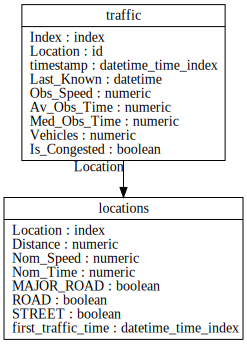

In [15]:
es.plot()

### Generating Features with Deep Feature Synthesis

In [16]:
cutoff_times = es['traffic'].df[['Index', 'Last_Known', 'Is_Congested' ]]

In [17]:
cutoff_times.head(15)

,Index,Last_Known,Is_Congested
3796,3796,2014-02-13 11:15:00,0
2720,2720,2014-02-13 12:05:00,0
3894,3894,2014-02-13 12:10:00,1
904,904,2014-02-13 12:20:00,1
3609,3609,2014-02-13 13:05:00,0
5199,5199,2014-02-13 14:00:00,0
1581,1581,2014-02-13 14:10:00,0
6692,6692,2014-02-13 14:30:00,0
1788,1788,2014-02-13 14:55:00,0
4774,4774,2014-02-13 15:10:00,0


In [18]:
# Generate features using the constructed entityset
fm, features = ft.dfs(entityset=es,
                      target_entity='traffic',
                      agg_primitives=['count', 'percent_true', 'max',
                                     'mean', 'sum', ],
                      trans_primitives=['is_weekend', 'weekday', 'day', 
                                        'month', 'year', 'week', 'minute', 'hour',
                                        'cum_sum', 'cum_count'
                                       ],
                      max_depth=3,
                      approximate='6h',
                      cutoff_time=cutoff_times,
                      n_jobs = 3,
                      verbose=True)

Built 98 features
EntitySet scattered to 3 workers in 1 seconds
Elapsed: 01:56 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [19]:
pd.set_option('display.max_rows', 100)
ft.list_primitives()

,name,type,description
0,mode,aggregation,Determines the most commonly repeated value.
1,trend,aggregation,Calculates the trend of a variable over time.
2,percent_true,aggregation,Determines the percent of `True` values.
3,std,aggregation,Computes the dispersion relative to the mean v...
4,time_since_first,aggregation,Calculates the time elapsed since the first da...
5,mean,aggregation,Computes the average for a list of values.
6,num_true,aggregation,Counts the number of `True` values.
7,skew,aggregation,Computes the extent to which a distribution di...
8,time_since_last,aggregation,Calculates the time elapsed since the last dat...
9,num_unique,aggregation,"Determines the number of distinct values, igno..."


In [20]:
pd.reset_option('display.max_rows')

### List all Features that were built

In [21]:
print('Features: {}, Rows: {}'.format(fm.shape[1], fm.shape[0]))
fm.tail(10)

Features: 99, Rows: 7000


,Is_Congested_x,Location,Obs_Speed,Av_Obs_Time,Med_Obs_Time,Vehicles,Is_Congested_y,IS_WEEKEND(timestamp),IS_WEEKEND(Last_Known),WEEKDAY(timestamp),...,locations.CUM_SUM(MAX(traffic.Vehicles)),locations.CUM_SUM(MEAN(traffic.Obs_Speed)),locations.CUM_SUM(MEAN(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Med_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time)),locations.CUM_SUM(SUM(traffic.Med_Obs_Time)),locations.CUM_SUM(SUM(traffic.Vehicles)),locations.CUM_SUM(MINUTE(first_traffic_time))
Index,,,,,,,,,,,,,,,,,,,,,
1145,0,192840,36,111,111,0,0,False,False,3,...,9.0,37.687500,101.187500,101.187500,1.687500,603.0,1619.0,1619.0,27.0,660
6143,1,187748,20,104,104,1,1,False,False,3,...,76.0,379.307511,936.169509,936.169509,18.770526,6282.0,15273.0,15273.0,315.0,9470
2925,0,178739,69,21,21,10,0,False,False,3,...,29.0,53.333333,29.611111,29.611111,9.722222,960.0,533.0,533.0,175.0,2735
3047,0,206422,51,70,70,0,0,False,False,3,...,60.0,247.746782,467.708371,467.708371,18.642911,4248.0,8913.0,8913.0,324.0,5065
4791,1,201481,32,118,118,9,1,False,False,3,...,53.0,172.927778,256.550000,256.550000,17.416667,2767.0,4064.0,4064.0,299.0,3975
4079,0,192438,34,88,88,19,0,False,False,3,...,42.0,130.316667,159.494444,159.494444,13.472222,2000.0,2317.0,2317.0,228.0,3325
3110,1,180926,29,98,98,27,1,False,False,3,...,81.0,340.232497,873.813133,873.813133,26.133387,5585.0,14676.0,14676.0,435.0,7350
1367,1,190285,36,72,72,3,1,False,False,3,...,36.0,92.066667,104.744444,104.744444,12.388889,1541.0,1660.0,1660.0,215.0,2840
2250,0,201373,53,114,114,4,0,False,False,3,...,65.0,298.032497,796.279800,796.279800,20.000054,4952.0,13513.0,13513.0,343.0,5185


In [22]:
fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 3796 to 959
Data columns (total 99 columns):
Is_Congested_x                                            7000 non-null int64
Location                                                  7000 non-null int64
Obs_Speed                                                 7000 non-null int64
Av_Obs_Time                                               7000 non-null int64
Med_Obs_Time                                              7000 non-null int64
Vehicles                                                  7000 non-null int64
Is_Congested_y                                            7000 non-null int64
IS_WEEKEND(timestamp)                                     7000 non-null bool
IS_WEEKEND(Last_Known)                                    7000 non-null bool
WEEKDAY(timestamp)                                        7000 non-null int64
WEEKDAY(Last_Known)                                       7000 non-null int64
DAY(timestamp)                     

## Model Testing

In [23]:
# cols = [c for c in fm.columns if c != 'no_show']
# fm = fm[cols]

In [24]:
X = fm.copy().fillna(0)
X.head()

,Is_Congested_x,Location,Obs_Speed,Av_Obs_Time,Med_Obs_Time,Vehicles,Is_Congested_y,IS_WEEKEND(timestamp),IS_WEEKEND(Last_Known),WEEKDAY(timestamp),...,locations.CUM_SUM(MAX(traffic.Vehicles)),locations.CUM_SUM(MEAN(traffic.Obs_Speed)),locations.CUM_SUM(MEAN(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Med_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time)),locations.CUM_SUM(SUM(traffic.Med_Obs_Time)),locations.CUM_SUM(SUM(traffic.Vehicles)),locations.CUM_SUM(MINUTE(first_traffic_time))
Index,,,,,,,,,,,,,,,,,,,,,
3796,0,158655,106,226,226,12,0,False,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
2720,0,201291,0,0,0,0,0,False,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
3894,1,192734,38,86,86,3,1,False,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90
904,1,187589,23,121,121,0,1,False,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130
3609,0,158684,105,228,228,9,0,False,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155


In [25]:
label = X.pop('Is_Congested_x')
label.head()

Index
3796    0
2720    0
3894    1
904     1
3609    0
Name: Is_Congested_x, dtype: int64

In [26]:
X.columns

Index(['Location', 'Obs_Speed', 'Av_Obs_Time', 'Med_Obs_Time', 'Vehicles',
       'Is_Congested_y', 'IS_WEEKEND(timestamp)', 'IS_WEEKEND(Last_Known)',
       'WEEKDAY(timestamp)', 'WEEKDAY(Last_Known)', 'DAY(timestamp)',
       'DAY(Last_Known)', 'MONTH(timestamp)', 'MONTH(Last_Known)',
       'YEAR(timestamp)', 'YEAR(Last_Known)', 'WEEK(timestamp)',
       'WEEK(Last_Known)', 'MINUTE(timestamp)', 'MINUTE(Last_Known)',
       'HOUR(timestamp)', 'HOUR(Last_Known)', 'CUM_SUM(Obs_Speed)',
       'CUM_SUM(Av_Obs_Time)', 'CUM_SUM(Med_Obs_Time)', 'CUM_SUM(Vehicles)',
       'CUM_COUNT(Location)', 'locations.Distance', 'locations.Nom_Speed',
       'locations.Nom_Time', 'locations.MAJOR_ROAD', 'locations.ROAD',
       'locations.STREET', 'CUM_SUM(MINUTE(timestamp))',
       'CUM_SUM(MINUTE(Last_Known))', 'locations.COUNT(traffic)',
       'locations.PERCENT_TRUE(traffic.Is_Congested)',
       'locations.MAX(traffic.Obs_Speed)',
       'locations.MAX(traffic.Av_Obs_Time)',
       'locations.MA

In [27]:
X = X.drop(['Obs_Speed', 'Av_Obs_Time', 'Med_Obs_Time', 'Vehicles', 'Is_Congested_y'], axis = 'columns')

In [28]:
X.columns

Index(['Location', 'IS_WEEKEND(timestamp)', 'IS_WEEKEND(Last_Known)',
       'WEEKDAY(timestamp)', 'WEEKDAY(Last_Known)', 'DAY(timestamp)',
       'DAY(Last_Known)', 'MONTH(timestamp)', 'MONTH(Last_Known)',
       'YEAR(timestamp)', 'YEAR(Last_Known)', 'WEEK(timestamp)',
       'WEEK(Last_Known)', 'MINUTE(timestamp)', 'MINUTE(Last_Known)',
       'HOUR(timestamp)', 'HOUR(Last_Known)', 'CUM_SUM(Obs_Speed)',
       'CUM_SUM(Av_Obs_Time)', 'CUM_SUM(Med_Obs_Time)', 'CUM_SUM(Vehicles)',
       'CUM_COUNT(Location)', 'locations.Distance', 'locations.Nom_Speed',
       'locations.Nom_Time', 'locations.MAJOR_ROAD', 'locations.ROAD',
       'locations.STREET', 'CUM_SUM(MINUTE(timestamp))',
       'CUM_SUM(MINUTE(Last_Known))', 'locations.COUNT(traffic)',
       'locations.PERCENT_TRUE(traffic.Is_Congested)',
       'locations.MAX(traffic.Obs_Speed)',
       'locations.MAX(traffic.Av_Obs_Time)',
       'locations.MAX(traffic.Med_Obs_Time)',
       'locations.MAX(traffic.Vehicles)', 'locations.ME

In [29]:
X.head()

,Location,IS_WEEKEND(timestamp),IS_WEEKEND(Last_Known),WEEKDAY(timestamp),WEEKDAY(Last_Known),DAY(timestamp),DAY(Last_Known),MONTH(timestamp),MONTH(Last_Known),YEAR(timestamp),...,locations.CUM_SUM(MAX(traffic.Vehicles)),locations.CUM_SUM(MEAN(traffic.Obs_Speed)),locations.CUM_SUM(MEAN(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Med_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time)),locations.CUM_SUM(SUM(traffic.Med_Obs_Time)),locations.CUM_SUM(SUM(traffic.Vehicles)),locations.CUM_SUM(MINUTE(first_traffic_time))
Index,,,,,,,,,,,,,,,,,,,,,
3796,158655,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
2720,201291,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
3894,192734,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90
904,187589,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130
3609,158684,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155


### Train-Test Split

#### Based on Health example

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.30, shuffle=False)

In [31]:
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
print('AUC score of {:.2f}'.format(roc_auc_score(y_test, probs[:,1])))

AUC score of 0.72


In [32]:
feature_imps = [(imp, X.columns[i]) for i, imp in enumerate(clf.feature_importances_)]
feature_imps.sort()
feature_imps.reverse()
print('Random Forest Feature Importances:')
for i, f in enumerate(feature_imps[0:25]):
    print('{}: {} [{:.3f}]'.format(i + 1, f[1], f[0]/feature_imps[0][0]))

Random Forest Feature Importances:
1: locations.PERCENT_TRUE(traffic.Is_Congested) [1.000]
2: Location [0.653]
3: locations.MEAN(traffic.Obs_Speed) [0.555]
4: locations.Nom_Time [0.421]
5: locations.Distance [0.366]
6: HOUR(Last_Known) [0.365]
7: locations.Nom_Speed [0.351]
8: HOUR(timestamp) [0.340]
9: locations.CUM_SUM(PERCENT_TRUE(traffic.Is_Congested)) [0.327]
10: locations.MAX(traffic.Obs_Speed) [0.319]
11: locations.MEAN(traffic.Av_Obs_Time) [0.282]
12: locations.MAX(traffic.Av_Obs_Time) [0.272]
13: locations.MAX(traffic.Med_Obs_Time) [0.272]
14: locations.MEAN(traffic.Med_Obs_Time) [0.265]
15: locations.CUM_SUM(SUM(traffic.Vehicles)) [0.259]
16: locations.CUM_SUM(SUM(traffic.Obs_Speed)) [0.257]
17: locations.CUM_SUM(SUM(traffic.Av_Obs_Time)) [0.248]
18: locations.MEAN(traffic.MINUTE(timestamp)) [0.245]
19: locations.SUM(traffic.Med_Obs_Time) [0.244]
20: locations.SUM(traffic.Av_Obs_Time) [0.239]
21: locations.HOUR(first_traffic_time) [0.235]
22: locations.CUM_SUM(MEAN(traffic.Ve

### Pickle this model for Flask

In [37]:
# Reduce the model to top 5 features

X_small = X[['locations.PERCENT_TRUE(traffic.Is_Congested)', 'Location',
            'locations.MEAN(traffic.Obs_Speed)', 'locations.Nom_Time',
            'locations.Distance']]

In [38]:
X_small.head()

,locations.PERCENT_TRUE(traffic.Is_Congested),Location,locations.MEAN(traffic.Obs_Speed),locations.Nom_Time,locations.Distance
Index,,,,,
3796,0.0,158655,0.0,219,6715
2720,0.0,201291,0.0,82,906
3894,0.0,192734,0.0,74,918
904,0.0,187589,0.0,93,802
3609,0.0,158684,0.0,219,6695


In [39]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_small, label, test_size=0.20, shuffle=False)



In [40]:
clf_small = RandomForestClassifier(n_estimators=150)
clf_small.fit(X_s_train, y_s_train)
probs = clf_small.predict_proba(X_s_test)
print('AUC score of {:.2f}'.format(roc_auc_score(y_s_test, probs[:,1])))

AUC score of 0.70


In [46]:
feature_imps = [(imp, X_small.columns[i]) for i, imp in enumerate(clf_small.feature_importances_)]
feature_imps.sort()
feature_imps.reverse()
print('Random Forest Feature Importances:')
for i, f in enumerate(feature_imps[0:10]):
    print('{}: {} [{:.3f}]'.format(i + 1, f[1], f[0]/feature_imps[0][0]))

Random Forest Feature Importances:
1: locations.MEAN(traffic.Obs_Speed) [1.000]
2: locations.PERCENT_TRUE(traffic.Is_Congested) [0.694]
3: Location [0.486]
4: locations.Distance [0.361]
5: locations.Nom_Time [0.340]


In [47]:
with open("rf_s_model.p", "wb") as f:
    pickle.dump(clf_small, f)

In [58]:
clf_small.predict(X_s_test)[0]

0

### Plotting Model Results

In [43]:
def plot_roc_auc(y_test, probs, pos_label=1):
    fpr, tpr, thresholds = roc_curve(y_test, 
                                     probs[:, 1], 
                                     pos_label=pos_label)


    output_notebook()
    p = figure(height=400, width=400)
    p.line(x=fpr, y=tpr)
    p.title.text ='Receiver operating characteristic'
    p.xaxis.axis_label = 'False Positive Rate'
    p.yaxis.axis_label = 'True Positive Rate'

    p.line(x=fpr, y=fpr, color='red', line_dash='dashed')
    return(p)

def plot_f1(y_test, probs, nprecs):
    threshes = [x/1000. for x in range(50, nprecs)]
    precisions = [precision_score(y_test, probs[:,1] > t) for t in threshes]
    recalls = [recall_score(y_test, probs[:,1] > t) for t in threshes]
    fones = [f1_score(y_test, probs[:,1] > t) for t in threshes]
    
    output_notebook()
    p = figure(height=400, width=400)
    p.line(x=threshes, y=precisions, color='green', legend='precision')
    p.line(x=threshes, y=recalls, color='blue', legend='recall')
    p.line(x=threshes, y=fones, color='red', legend='f1')
    p.xaxis.axis_label = 'Threshold'
    p.title.text = 'Precision, Recall, and F1 by Threshold'
    return(p)

def plot_kfirst(ytest, probs, firstk=500):
    A = pd.DataFrame(probs)
    A['y_test'] = y_test.values
    krange = range(firstk)
    firstk = []
    for K in krange:
        a = A[1][:K]
        a = [1 for prob in a]
        b = A['y_test'][:K]
        firstk.append(precision_score(b, a))
    
    output_notebook()
    p = figure(height=400, width=400)
    p.step(x=krange, y=firstk)
    p.xaxis.axis_label = 'Predictions sorted by most likely'
    p.yaxis.axis_label = 'Precision'
    p.title.text = 'K-first'
    p.yaxis[0].formatter.use_scientific = False
    return p

p1 = plot_roc_auc(y_test, probs)
p2 = plot_f1(y_test, probs, 1000)
p3 = plot_kfirst(y_test, probs, 300)

Loading BokehJS ...

/Users/farsyd/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/farsyd/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Loading BokehJS ...

Loading BokehJS ...

In [44]:
show(gridplot([p1, p2, p3], ncols=1))

#### From Education Example

#### Function for Feature Importance

In [56]:
def feature_importances(fm_enc, clf, feats=20):
    feature_imps = [(imp, fm_enc.columns[i])
                    for i, imp in enumerate(clf.feature_importances_)]
    feature_imps.sort()
    feature_imps.reverse()
    print('Feature Importances: ')
    for i, f in enumerate(feature_imps[0:feats]):
        print('{}: {}'.format(i + 1, f[1]))
    print("-----\n")
    return ([f[1] for f in feature_imps[0:feats]])

In [57]:
# 1. Split X and y into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.30, shuffle=False)

In [58]:
# 2. Select features using RFE
clf = RandomForestClassifier(n_estimators=10)
estimator = clf
selector = RFE(estimator, 20, step=1)
selector = selector.fit(X_train, y_train)
X_train.iloc[:, selector.support_].tail()

,Location,HOUR(timestamp),HOUR(Last_Known),CUM_SUM(Obs_Speed),CUM_SUM(Av_Obs_Time),CUM_SUM(Med_Obs_Time),locations.Distance,locations.Nom_Speed,locations.Nom_Time,locations.PERCENT_TRUE(traffic.Is_Congested),locations.MEAN(traffic.Obs_Speed),locations.MEAN(traffic.Av_Obs_Time),locations.MEAN(traffic.Med_Obs_Time),locations.SUM(traffic.Med_Obs_Time),locations.MEAN(traffic.MINUTE(timestamp)),locations.CUM_SUM(PERCENT_TRUE(traffic.Is_Congested)),locations.CUM_SUM(MAX(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time))
Index,,,,,,,,,,,,,,,,,,,,
1703,158865,11,10,216045,511577,511577,920,81,41,0.750000,65.625000,50.375000,50.375000,403.0,31.875000,3.716884,2762.0,38.704230,7100.0,15921.0
5775,178713,11,10,216118,511597,511597,406,43,34,0.000000,68.500000,23.000000,23.000000,230.0,24.500000,1.895738,1886.0,26.152226,3894.0,9546.0
2389,195552,11,11,216144,511746,511746,1090,42,93,0.461538,36.538462,117.307692,117.307692,1525.0,27.692308,0.643357,1089.0,9.377622,1515.0,4797.0
3772,203530,11,11,216175,511880,511880,1161,40,104,0.272727,23.727273,72.272727,72.272727,795.0,27.272727,2.603247,2445.0,31.467866,5749.0,13780.0
3434,190338,12,11,216192,511979,511979,494,19,95,0.000000,47.545455,51.363636,51.363636,565.0,21.363636,1.895738,1981.0,26.515862,4417.0,10111.0


In [59]:
# 3. Train a Random Forest Classifier
clf.fit(selector.transform(X_train), y_train)

# 4. Make predictions and score
probs = clf.predict_proba(selector.transform(X_test))
print("Auc score of {:.3f}".format(roc_auc_score(y_test, probs[:,1])))

feats = feature_importances(X_train.iloc[:, selector.support_], clf)

Auc score of 0.692
Feature Importances: 
1: locations.PERCENT_TRUE(traffic.Is_Congested)
2: Location
3: locations.MEAN(traffic.Obs_Speed)
4: locations.Distance
5: CUM_SUM(Med_Obs_Time)
6: locations.CUM_SUM(SUM(traffic.Obs_Speed))
7: locations.CUM_SUM(PERCENT_TRUE(traffic.Is_Congested))
8: HOUR(timestamp)
9: locations.CUM_SUM(SUM(traffic.Av_Obs_Time))
10: locations.Nom_Time
11: CUM_SUM(Obs_Speed)
12: locations.SUM(traffic.Med_Obs_Time)
13: locations.CUM_SUM(MAX(traffic.Av_Obs_Time))
14: HOUR(Last_Known)
15: locations.MEAN(traffic.Av_Obs_Time)
16: locations.CUM_SUM(MEAN(traffic.Vehicles))
17: CUM_SUM(Av_Obs_Time)
18: locations.MEAN(traffic.Med_Obs_Time)
19: locations.MEAN(traffic.MINUTE(timestamp))
20: locations.Nom_Speed
-----



## EDA and Baselining

In [62]:
eda_df = fm.copy()

In [63]:
eda_df.head()

,Is_Congested_x,Location,Obs_Speed,Av_Obs_Time,Med_Obs_Time,Vehicles,Is_Congested_y,IS_WEEKEND(timestamp),IS_WEEKEND(Last_Known),WEEKDAY(timestamp),...,locations.CUM_SUM(MAX(traffic.Vehicles)),locations.CUM_SUM(MEAN(traffic.Obs_Speed)),locations.CUM_SUM(MEAN(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Med_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time)),locations.CUM_SUM(SUM(traffic.Med_Obs_Time)),locations.CUM_SUM(SUM(traffic.Vehicles)),locations.CUM_SUM(MINUTE(first_traffic_time))
Index,,,,,,,,,,,,,,,,,,,,,
3796,0,158655,106,226,226,12,0,False,False,3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,35
2720,0,201291,0,0,0,0,0,False,False,3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,60
3894,1,192734,38,86,86,3,1,False,False,3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,90
904,1,187589,23,121,121,0,1,False,False,3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,130
3609,0,158684,105,228,228,9,0,False,False,3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,155


In [65]:
eda_df.groupby('Is_Congested_x').mean()

,Location,Obs_Speed,Av_Obs_Time,Med_Obs_Time,Vehicles,Is_Congested_y,IS_WEEKEND(timestamp),IS_WEEKEND(Last_Known),WEEKDAY(timestamp),WEEKDAY(Last_Known),...,locations.CUM_SUM(MAX(traffic.Vehicles)),locations.CUM_SUM(MEAN(traffic.Obs_Speed)),locations.CUM_SUM(MEAN(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Med_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time)),locations.CUM_SUM(SUM(traffic.Med_Obs_Time)),locations.CUM_SUM(SUM(traffic.Vehicles)),locations.CUM_SUM(MINUTE(first_traffic_time))
Is_Congested_x,,,,,,,,,,,,,,,,,,,,,
0,191233.105101,50.340395,75.362197,75.362197,2.818182,0.0,0.316536,0.316536,3.112094,3.116002,...,45.503735,221.193409,485.437228,485.437228,16.955741,1839.818799,4036.544426,4036.544426,139.342452,5977.799260
1,188275.095416,29.085594,171.366698,171.366698,3.827409,1.0,0.230122,0.230589,2.768007,2.769878,...,45.943415,219.729514,520.509512,520.509512,16.981269,1867.985500,4403.030870,4403.030870,138.845650,6264.576707


In [66]:
fm.columns

Index(['Is_Congested_x', 'Location', 'Obs_Speed', 'Av_Obs_Time',
       'Med_Obs_Time', 'Vehicles', 'Is_Congested_y', 'IS_WEEKEND(timestamp)',
       'IS_WEEKEND(Last_Known)', 'WEEKDAY(timestamp)', 'WEEKDAY(Last_Known)',
       'DAY(timestamp)', 'DAY(Last_Known)', 'MONTH(timestamp)',
       'MONTH(Last_Known)', 'YEAR(timestamp)', 'YEAR(Last_Known)',
       'WEEK(timestamp)', 'WEEK(Last_Known)', 'MINUTE(timestamp)',
       'MINUTE(Last_Known)', 'HOUR(timestamp)', 'HOUR(Last_Known)',
       'CUM_SUM(Obs_Speed)', 'CUM_SUM(Av_Obs_Time)', 'CUM_SUM(Med_Obs_Time)',
       'CUM_SUM(Vehicles)', 'CUM_COUNT(Location)', 'locations.Distance',
       'locations.Nom_Speed', 'locations.Nom_Time', 'locations.MAJOR_ROAD',
       'locations.ROAD', 'locations.STREET', 'CUM_SUM(MINUTE(timestamp))',
       'CUM_SUM(MINUTE(Last_Known))', 'locations.COUNT(traffic)',
       'locations.PERCENT_TRUE(traffic.Is_Congested)',
       'locations.MAX(traffic.Obs_Speed)',
       'locations.MAX(traffic.Av_Obs_Time)',
  

In [73]:
def plot_features(df, feature, sample_size=500):
    sample = (df[['Is_Congested_x', feature]]
                .sample(1000, random_state=13)) 
    sns.pairplot(sample,hue='Is_Congested_x', plot_kws=dict(alpha=.3, edgecolor='none'))


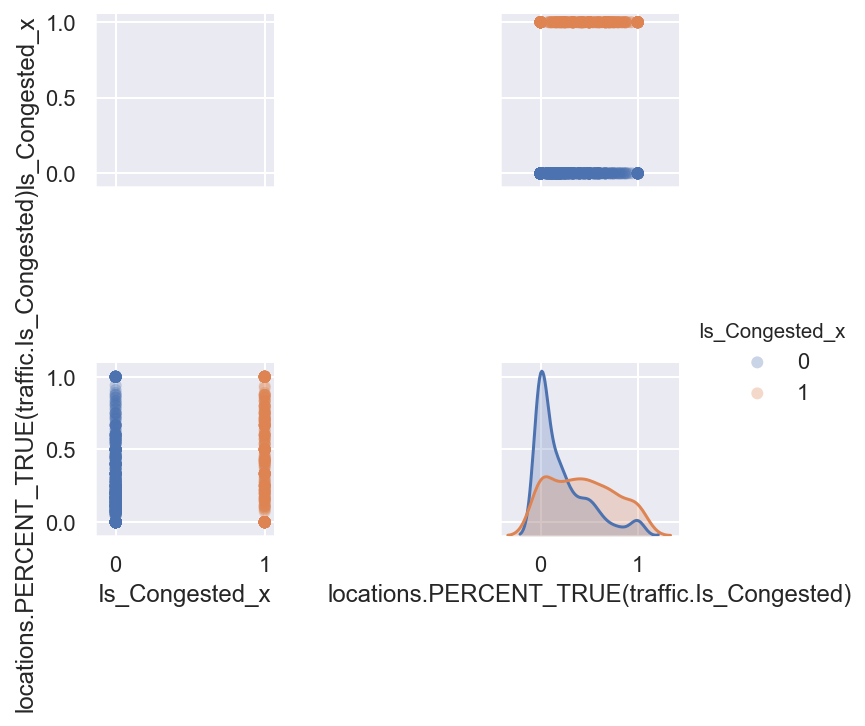

In [74]:
plot_features(eda_df, 'locations.PERCENT_TRUE(traffic.Is_Congested)')

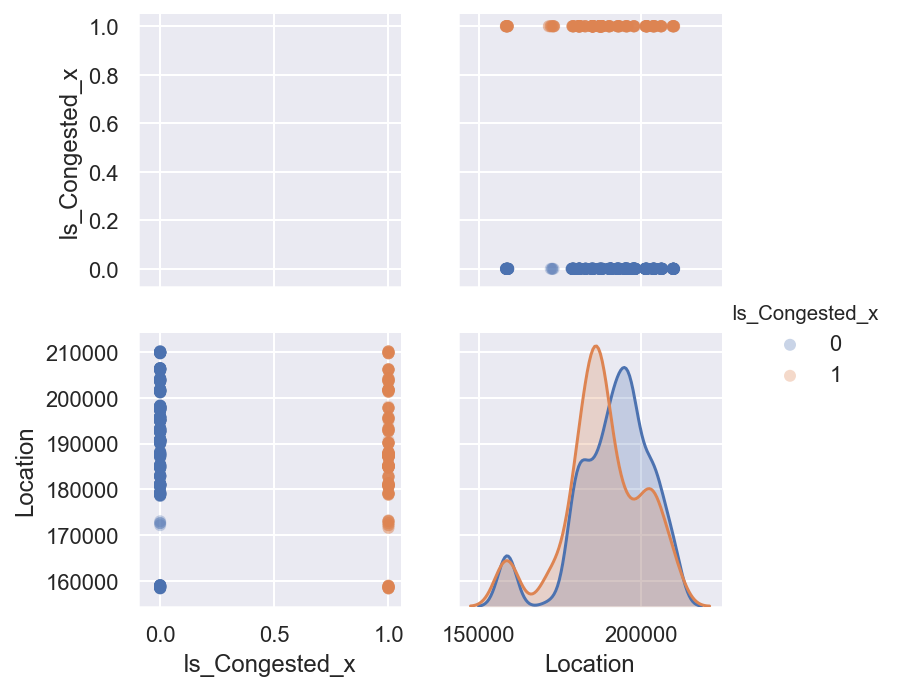

In [75]:
plot_features(eda_df, 'Location')

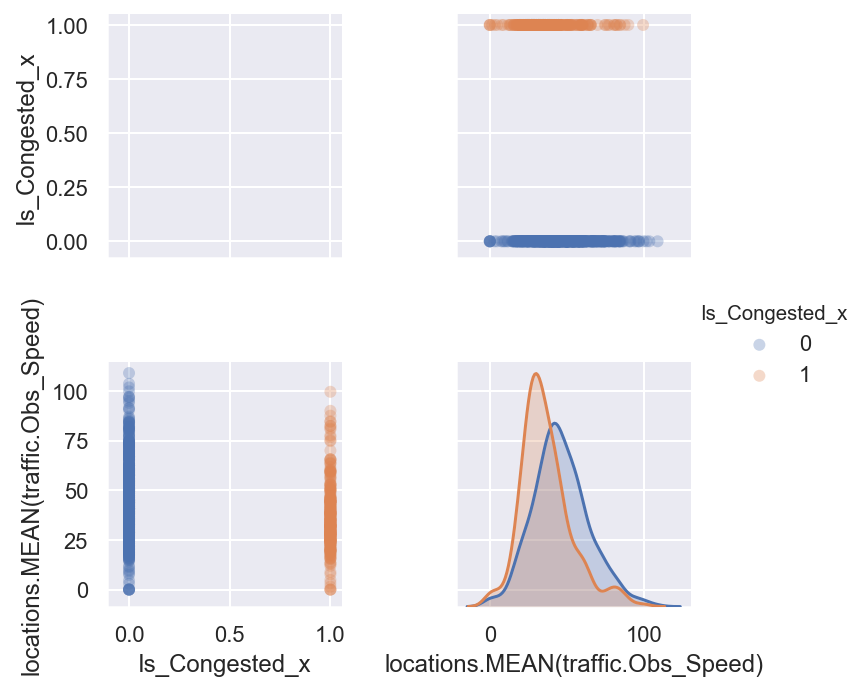

In [76]:
plot_features(eda_df, 'locations.MEAN(traffic.Obs_Speed)')

In [ ]:
# # histogram of Observed Speed
# traf_init['Obs_Speed'].hist()
# plt.title('Histogram of Observed Speed')
# plt.xlabel('Observed Speed')
# plt.ylabel('Frequency')

In [ ]:
# # histogram of Vehicles
# sns.distplot(traf_init['Vehicles'])
# # traf_init['Vehicles'].hist()
# plt.title('Histogram of # of Vehicles')
# plt.xlabel('# of Vehicles')
# plt.ylabel('Frequency')

In [ ]:
# # histogram of Vehicles
# # sns.distplot(traf_init['Vehicles'])
# traf_init['Vehicles'].hist()
# plt.title('Histogram of # of Vehicles')
# plt.xlabel('# of Vehicles')
# plt.ylabel('Frequency')

## Pickle X and y for use with different models

In [83]:
X.head(15)

,Location,IS_WEEKEND(timestamp),IS_WEEKEND(Last_Known),WEEKDAY(timestamp),WEEKDAY(Last_Known),DAY(timestamp),DAY(Last_Known),MONTH(timestamp),MONTH(Last_Known),YEAR(timestamp),...,locations.CUM_SUM(MAX(traffic.Vehicles)),locations.CUM_SUM(MEAN(traffic.Obs_Speed)),locations.CUM_SUM(MEAN(traffic.Av_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Med_Obs_Time)),locations.CUM_SUM(MEAN(traffic.Vehicles)),locations.CUM_SUM(SUM(traffic.Obs_Speed)),locations.CUM_SUM(SUM(traffic.Av_Obs_Time)),locations.CUM_SUM(SUM(traffic.Med_Obs_Time)),locations.CUM_SUM(SUM(traffic.Vehicles)),locations.CUM_SUM(MINUTE(first_traffic_time))
Index,,,,,,,,,,,,,,,,,,,,,
3796,158655,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
2720,201291,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
3894,192734,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90
904,187589,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130
3609,158684,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155
5199,158505,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175
1581,190312,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205
6692,158475,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255
1788,201615,False,False,3,3,13,13,2,2,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270


In [84]:
with open('X.pickle', 'wb') as to_write:
    pickle.dump(X, to_write)

In [85]:
y = label

In [86]:
y.head(15)

Index
3796    0
2720    0
3894    1
904     1
3609    0
5199    0
1581    0
6692    0
1788    0
4774    0
1606    1
2636    1
6623    0
181     1
3433    0
Name: Is_Congested_x, dtype: int64

In [87]:
with open('y.pickle', 'wb') as to_write:
    pickle.dump(y, to_write)